# IP21 and Alarm data analyse

Author: Mark Chinnock, Anova Data Solutions   
Date: July 2021   
## Content

Introduction

    1.1 Background

    1.2 Problem

    1.3 Audience

    Data
    Methodology
    Results
    Discussion
    Conclusion



## Introduction

IP21 data is a generic name given to data recorded from machine sensors on each of the manufacturing lines.  The sensors provide readings of (but not exclusively): temperature, humidity, pressure, and counters.   
<p>The readings come from the machines at regular timed intervals (time series data) regardless of the current reading/performance from the sensor – ie it is not alerting of a specific scenario/reading.  Each sensor is documented on a detailed schematic and named so that it can be mapped to a plant/line/machine/sensor type.
<p>There are also alerts/alarms that are issued from the manufacturing lines.  The alarms have also been named to indicate specific areas / machines.  Although often mentioned along with IP21, there is no direct correlation between the alerts/alarms being issued into one database and the IP21 data being issued into another database. There would need to be a complex mapping exercise to link specific alerts/alarms to related IP21 data.


Import some libraries

In [2]:
import pandas as pd
import numpy as np
import datetime

# this dir should point at where ever your sanofi Mclaren directory is syncing
# dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data/"

from sys import platform
# if platform == "linux" or platform == "linux2":
    # linux    
if platform == "darwin":
    # OS X
    dir = "/Users/mark/Documents/GitHub/IP21/"
elif platform == "win32":
    # Windows...
    # dir = "C:/Users/mark_/Documents/McLaren2021/Sanofi/IP21/"
    # trying the microsoft teams sanofi share folder
    dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/OEE data/"

    


In [3]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [4]:
# read Detailed Events file
file = (dir + 'AL6_Packaging_Detailed_Events.xlsx')
df = pd.read_excel(file, parse_dates=True, index_col='Start Date')

# read in OEE losses
file = (dir + 'AL6_OEE_Losses.xlsx')
df_OEE = pd.read_excel(file)
df_OEE.rename(columns=({'Calendar Day':'Date', 
                        'Point of OEE':'OEE',
                        'Loss Category':'Category'}), inplace=True)
df_OEE['OEE'] = pd.to_numeric(df_OEE['OEE'], errors='coerce')
df_OEE['OEE'] = df_OEE['OEE'].mul(100)
df_OEE = df_OEE.set_index('Date')
df_OEE.shape

(2741, 2)

get rid of any pre April 2021 data - wasn't valid for AL6

In [5]:
start_date = '2021-04-01'
end_date = datetime.date.today()
df_OEE = df_OEE[df_OEE.index >= start_date].sort_values('Date')
df_OEE.Category.unique()

array(['Qualifizierung/Validierung (11)', 'Production', 'Minor Loss',
       'Without cause', 'Sonstiges und Unbekannte (26)',
       'Störungen und Fehlerbehebung (25)', 'Speed Loss',
       'W&I (geplante Linie) (23)',
       'Organisatorische Verluste und Wartezeiten (22)',
       'Rüstvorgänge (21)', 'Ungeplante Linie (14)',
       'Feier/Brückentag (12)', 'Autonome Wartungen (24)',
       'vorbeugende Instandhaltung/Wartung (13)', 'Sonstige (15)',
       'Quality Loss'], dtype=object)

In [6]:
df.head()

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator
Start Date,,,,,,,,
2021-04-01 06:05:43,FRUE - 01/04/2021 06:00:00,2021-04-01 06:06:33,0.833333,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:22:19,FRUE - 01/04/2021 06:00:00,2021-04-01 06:23:43,1.400000,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:54:09,FRUE - 01/04/2021 06:00:00,2021-04-01 06:55:52,1.716667,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:56:00,FRUE - 01/04/2021 06:00:00,2021-04-01 06:57:59,1.983333,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:58:05,FRUE - 01/04/2021 06:00:00,2021-04-01 06:59:42,1.616667,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH


Let's translate these stoppage categories!

| German | English | 
| ------ | ------- |
|Qualifizierung/Validierung (11)|Qualification/validation|    
|Sonstiges und Unbekannte (26)|Other and unknown|   
|Störungen und Fehlerbehebung (25)|Malfunctions and troubleshooting|    
|W&I (geplante Linie) (23)|W&I (planned line)|   
|Organisatorische Verluste und Wartezeiten (22)|Organizational losses and waiting times|   
|Rüstvorgänge (21)|Changeover|    
|Ungeplante Linie (14)|Unplanned Line|   
|Feier/Brückentag (12)|Celebration / long day|   
|Autonome Wartungen (24)|Autonomous maintenance|   
|vorbeugende Instandhaltung/Wartung (13)|Preventive maintenance / servicing|   
|Sonstige (15)|Other|   



In [7]:
df_OEE['Category'].replace({
'Qualifizierung/Validierung (11)':'Qualification/validation', 
'Sonstiges und Unbekannte (26)':'Other and unknown',
'Störungen und Fehlerbehebung (25)':'Malfunctions and troubleshooting', 
'W&I (geplante Linie) (23)':'W&I (planned line)',
'Organisatorische Verluste und Wartezeiten (22)':'Organizational losses and waiting times',
'Rüstvorgänge (21)':'Changeover', 
'Ungeplante Linie (14)':'Unplanned Line',
'Feier/Brückentag (12)':'Celebration / long day', 
'Autonome Wartungen (24)':'Autonomous maintenance',
'vorbeugende Instandhaltung/Wartung (13)':'Preventive maintenance / servicing', 
'Sonstige (15)':'Other'}, inplace=True)

df['Stoppage Reason 3'].replace({
'Qualifizierung/Validierung (11)':'Qualification/validation', 
'Sonstiges und Unbekannte (26)':'Other and unknown',
'Störungen und Fehlerbehebung (25)':'Malfunctions and troubleshooting', 
'W&I (geplante Linie) (23)':'W&I (planned line)',
'Organisatorische Verluste und Wartezeiten (22)':'Organizational losses and waiting times',
'Rüstvorgänge (21)':'Changeover', 
'Ungeplante Linie (14)':'Unplanned Line',
'Feier/Brückentag (12)':'Celebration / long day', 
'Autonome Wartungen (24)':'Autonomous maintenance',
'vorbeugende Instandhaltung/Wartung (13)':'Preventive maintenance / servicing', 
'Sonstige (15)':'Other'}, inplace=True)

In [8]:
# do I need this?  

# set up date range with min start_date and max start_date recorded earlier
daterange = pd.date_range(start = start_date, end = end_date, freq='D')

pd.DataFrame({'Date': daterange.date})

# df = pd.merge(df1, df, on=['Date','UI'], how='outer')

,Date
0,2021-04-01
1,2021-04-02
2,2021-04-03
3,2021-04-04
4,2021-04-05
...,...
113,2021-07-23
114,2021-07-24
115,2021-07-25
116,2021-07-26


In [9]:
df_OEE['Month'] = df_OEE.index.strftime("%B")
df_OEE['Day'] = df_OEE.index.strftime("%d")
df_OEE.head()

# df_OEE.groupby(['Day', 'Month', 'Category'])[['OEE']].sum()

df_OEE['Month'] = df_OEE['Month'].astype(pd.api.types.CategoricalDtype(categories=['April','May','June', 'July'], ordered=True))


production = df_OEE[df_OEE.Category == ('Production')]
changeover = df_OEE[df_OEE.Category == ('Changeover')]

pivot = production.pivot(index='Day', columns='Month', values='OEE').style.background_gradient(cmap='Oranges_r')\
       # .format("{:.2f}")

pivot

Month,April,May,June,July
Day,,,,
01,43.382099,43.102778,54.364583,44.023148
02,16.429006,38.669444,21.286574,31.937310
03,61.401389,29.590123,44.448400,17.029861
04,0.008333,30.714903,80.177778,0.000000
05,nan,32.486574,53.335463,nan
06,27.228704,33.511179,18.668519,nan
07,33.662500,67.476157,29.443308,nan
08,50.584259,60.335648,39.222029,nan
09,49.161111,41.127778,25.174102,51.367983


In [10]:
pivot.to_excel(dir + "AL6_production_losses_pivot.xlsx")

In [11]:
category_order = ['Production',
'Organizational losses and waiting times', 
'Changeover', 
'Malfunctions and troubleshooting',
'Other and unknown', 
'Without cause', 
'Minor Loss', 
'Speed Loss', 
'Autonomous maintenance',
'Celebration / long day', 
'Other',
'Preventive maintenance / servicing', 
'Quality Loss',
'Unplanned Line',
'W&I (planned line)',
'Qualification/validation']

not using this one at the moment, as the categories are all over the place

In [40]:
writer = pd.ExcelWriter(dir + 'AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')
for i in df_OEE.Month.unique():
    pivot_OEE = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE').filter(regex=i)
    styler_OEE = pivot_OEE.style.background_gradient(cmap='Oranges')\
        .background_gradient(subset=['Production'], cmap='Greens')\
        # .format("{:,.2f}") # neither of these output to excel
        # .set_precision(2)  # neither of these output to excel
    
    styler_OEE.to_excel(writer, sheet_name=i)
    # pivot_OEE.to_excel(writer, sheet_name=i)
    workbook = writer.book
    worksheet = writer.sheets[i]
    # workbook = writer.book
    # cell_format = workbook.add.format()
    decimal = workbook.add_format({'num_format': '0.00'})
    worksheet.set_column('A:Q', 20, decimal)
#     call function get_col_widths to auto size the excel columns
    # for x, width in enumerate(get_col_widths(pivot_OEE)):
    #     #set each column width to be 1*25 that of the max string so that it fits nicely
    #     worksheet.set_column(x, x, width * 1.25)    



# workbook = writer.book
# writer.save() # don't save until we've added more sheets below

This sorts the pivot by category, then month.

In [22]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')

# pivot_OEE_sorted = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE')
# pivot_OEE_sorted.columns = pivot_OEE_sorted.columns.set_levels(
#     pd.CategoricalIndex(
#         pivot_OEE_sorted.columns.levels[0],
#         ['Production',
#         'Organizational losses and waiting times', 
#         'Changeover', 
#         'Malfunctions and troubleshooting',
#         'Other and unknown', 
#         'Without cause', 
#         'Minor Loss', 
#         'Speed Loss', 
#         'Autonomous maintenance',
#         'W&I (planned line)',
#         'Celebration / long day', 
#         'Other',
#         'Preventive maintenance / servicing', 
#         'Quality Loss',
#         'Unplanned Line',
#         'Qualification/validation'],
#         ordered=True
#     ), level=0
# )

# pivot_OEE_sorted = pivot_OEE_sorted.sort_index(axis=1).style.background_gradient(cmap='Oranges')\
#     .background_gradient(subset=['Production'], cmap='Purples')

# pivot_OEE_sorted.to_excel(writer)
# workbook = writer.book
# writer.save()

In [26]:
df_OEE.groupby(['Category','Month']).describe().transpose()

Category  Autonomous maintenance                                   \
Month                      April        May       June       July   
OEE count              29.000000  29.000000  26.000000  15.000000   
    mean                2.200777   2.992478   3.742103   2.113928   
    std                 4.408781   4.039306   5.025886   4.397251   
    min                 0.000000   0.000000   0.000000   0.000000   
    25%                 0.000000   0.000000   0.502025   0.000000   
    50%                 0.620370   1.012346   3.007995   0.726852   
    75%                 2.942130   4.481481   4.711516   1.332392   
    max                22.726852  15.724537  23.834491  16.607762   

Category  Celebration / long day           Changeover                        \
Month                      April  May June      April        May       June   
OEE count                    5.0  1.0  1.0  29.000000  29.000000  26.000000   
    mean                     0.0  0.0  0.0  10.866925   8.049728   6.767113   
    std                      0.0  NaN  NaN  18.301047   6.980477  10.173623   
    min                      0.0  0.0  0.0   0.000000   0.000000   0.000000   
    25%                      0.0  0.0  0.0   2.824074   1.851852   0.000000   
    50%                      0.0  0.0  0.0   7.143519   7.131944   3.182870   
    75%                      0.0  0.0  0.0  12.169753  11.748868  10.366030   
    max                      0.0  0.0  0.0  99.995370  29.032407  47.500000   

Category   ... Unplanned Line       W&I (planned line)                       \
Month      ...           June  July              April  May       June July   
OEE count  ...           26.0  15.0               12.0  8.0  12.000000  9.0   
    mean   ...            0.0   0.0                0.0  0.0   0.560957  0.0   
    std    ...            0.0   0.0                0.0  0.0   1.310115  0.0   
    min    ...            0.0   0.0                0.0  0.0   0.000000  0.0   
    25%    ...            0.0   0.0                0.0  0.0   0.000000  0.0   
    50%    ...            0.0   0.0                0.0  0.0   0.000000  0.0   
    75%    ...            0.0   0.0                0.0  0.0   0.000000  0.0   
    max    ...            0.0   0.0                0.0  0.0   3.371528  0.0   

Category  Without cause                                   
Month             April        May       June       July  
OEE count     29.000000  29.000000  26.000000  15.000000  
    mean       4.234435   7.735997   1.904903   1.585354  
    std        3.924070   7.918484   1.657682   1.479806  
    min        0.000000   0.000000   0.000000   0.000000  
    25%        1.516204   4.101852   0.527199   0.177662  
    50%        2.003472   6.299769   1.712269   1.416667  
    75%        6.394676   9.224993   3.304398   2.313601  
    max       12.229167  42.574074   5.504630   4.671296  

[8 rows x 62 columns]

In [27]:
pivot_OEE = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE')
pivot_OEE.stack()

Category   Autonomous maintenance  Celebration / long day  Changeover  \
Day Month                                                               
01  April                0.000000                     0.0   11.976852   
    May                  0.312500                     NaN    4.842593   
    June                 0.619213                     NaN    0.000000   
    July                 7.040509                     NaN    0.000000   
02  April                0.000000                     0.0   18.625000   
...                           ...                     ...         ...   
29  June                 1.216992                     NaN   11.150019   
30  April                0.000000                     NaN    7.019676   
    May                  0.000000                     NaN   29.032407   
    June                10.797222                     NaN    7.166667   
31  May                  1.012346                     NaN    0.000000   

Category   Malfunctions and troubleshooting  Minor Loss  \
Day Month                                                 
01  April                         22.481481   12.870370   
    May                           21.302083   23.060185   
    June                           2.065972   10.186343   
    July                          22.467593    8.652778   
02  April                         21.027778   14.275463   
...                                     ...         ...   
29  June                           9.029851    9.446996   
30  April                         11.686343   16.143519   
    May                            0.000000    7.166667   
    June                          14.008333    7.388889   
31  May                           34.214506    6.540123   

Category   Organizational losses and waiting times  Other  Other and unknown  \
Day Month                                                                      
01  April                                 3.421296    NaN          10.745370   
    May                                   0.701389    0.0           6.754630   
    June                                  1.945602    0.0           7.738426   
    July                                  3.653935    0.0           5.106481   
02  April                                 2.925926    NaN           9.358796   
...                                            ...    ...                ...   
29  June                                  9.169537    0.0           6.174895   
30  April                                 7.013889    NaN          10.497685   
    May                                  20.972222    NaN           7.490741   
    June                                  8.333333    0.0           0.725000   
31  May                                   0.000000    NaN           4.195988   

Category   Preventive maintenance / servicing  Production  \
Day Month                                                   
01  April                                 NaN   43.382099   
    May                                   0.0   43.102778   
    June                                  NaN   54.364583   
    July                                  NaN   44.023148   
02  April                                 0.0   16.429006   
...                                       ...         ...   
29  June                                  NaN   40.484561   
30  April                                 0.0   47.721528   
    May                                   NaN   26.219444   
    June                                  NaN   30.341111   
31  May                                   NaN   36.513889   

Category   Qualification/validation  Quality Loss  Speed Loss  Unplanned Line  \
Day Month                                                                       
01  April                       0.0           NaN   -6.983951             0.0   
    May                         0.0           NaN  -10.181481             0.0   
    June                        0.0           NaN   20.543981             0.0   
    July                        0.0       

In [28]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df.groupby([pd.Grouper(freq='D'), 'Machine'])['Duration (min.)'].mean().reset_index()
pivot = df_grouped.pivot(index='Start Date', columns='Machine', values='Duration (min.)')
pivot.fillna(0, inplace=True)
pivot['Total Duration'] = pivot.sum(axis=1)
styler_pivot = pivot.style.background_gradient(cmap='Purples')
styler_pivot.to_excel(writer, sheet_name='Detailed_Events (mins)')
worksheet = writer.sheets['Detailed_Events (mins)']
# workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

# workbook = writer.book
# workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


In [29]:
df.loc['2021-06-21'].groupby(['Machine','Stoppage Reason 3','Last Level Reason']).mean().sort_values('Duration (min.)', ascending=False)

Duration (min.)
Machine          Stoppage Reason 3                Last Level Reason                                      
AL6 Endverpacker Malfunctions and troubleshooting Kuka Roboter (251270601)                     106.766667
AL6 Kartonierer  Malfunctions and troubleshooting F2_224- Abholwerkzeug PENs (251440803)        17.750000
                 Minor Loss                       -                                              1.018333

In [30]:
df_date = df.loc['2021-06-21']

import the IP21 data for AL6 for the same date and map those outage times to IP21 data

In [75]:
# read in txt file
file = (dir + 'IP21_AL6_Aggregates_20210621.txt')
df_IP21_agg = pd.read_csv(file, parse_dates=True, index_col='Start Date', header=None, names=('name', 'Start Date', 'avg', 'min', 'max', 'std', 'sum'))
df_IP21_agg.shape

(248774, 6)

In [43]:
df_IP21_agg.shape

(248774, 6)

In [33]:
df_merge = pd.merge_asof(df_date.sort_index(), df_IP21_agg.sort_index(), left_index=True, right_index=True, allow_exact_matches=True, direction='forward')

In [34]:
df_merge.head()

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator,name,avg,min,max,std,sum
Start Date,,,,,,,,,,,,,,
2021-06-21 06:31:54,FRUE - 21/06/2021 06:00:00,2021-06-21 06:32:16,0.366667,Minor Loss,-,AL6 Kartonierer,Auto assignment,OEE_INTEGRATOR,36650901_LIFECOUNTER,39972.100000,39970.1,39974.100,1.177820,2.398330e+06
2021-06-21 06:43:59,FRUE - 21/06/2021 06:00:00,2021-06-21 06:45:47,1.800000,Minor Loss,-,AL6 Kartonierer,Auto assignment,OEE_INTEGRATOR,36630901_WATCHDOG,-0.476953,-1.0,0.000,0.293557,-2.861720e+01
2021-06-21 07:29:02,FRUE - 21/06/2021 06:00:00,2021-06-21 07:30:44,1.700000,Minor Loss,-,AL6 Kartonierer,Auto assignment,OEE_INTEGRATOR,36630901_S300HEIGHT_L7,0.000000,0.0,0.000,0.000000,0.000000e+00
2021-06-21 07:30:50,FRUE - 21/06/2021 06:00:00,2021-06-21 07:32:48,1.966667,Minor Loss,-,AL6 Kartonierer,Auto assignment,OEE_INTEGRATOR,36630901_S340HEIGHT_L16,82.390200,0.0,164.171,47.329300,4.943410e+03
2021-06-21 07:49:16,FRUE - 21/06/2021 06:00:00,2021-06-21 07:50:26,1.166667,Minor Loss,-,AL6 Kartonierer,Auto assignment,OEE_INTEGRATOR,36670901_CNTRB_ETK,0.000000,0.0,0.000,0.000000,0.000000e+00


In [35]:
df_merge.groupby(['Machine','name']).mean()

Duration (min.)           avg  \
Machine          name                                                     
AL6 Endverpacker 36630901_S130HEIGHT_L9        106.766667      0.670655   
AL6 Kartonierer  36630901_CNTRB_ST13             1.200000      0.000000   
                 36630901_CNTRB_ST3              0.483333      0.000000   
                 36630901_CNTRB_ST4              0.266667      0.000000   
                 36630901_CNTRB_ST9              0.900000     26.680000   
                 36630901_CNTRB_ZA_PCS           1.883333     64.925400   
                 36630901_S130HEIGHT_L1          0.300000      0.000000   
                 36630901_S130HEIGHT_L11         1.016667      0.000000   
                 36630901_S130HEIGHT_L13         0.916667      0.292963   
                 36630901_S130HEIGHT_L14         1.883333      0.439292   
                 36630901_S130HEIGHT_L15         0.766667      0.488957   
                 36630901_S130HEIGHT_L9          0.216667      0.477567   
                 36630901_S300HEIGHT_L7          1.700000      0.000000   
                 36630901_S340HEIGHT_L16         1.966667     82.390200   
                 36630901_S340HEIGHT_L9          0.433333    140.305000   
                 36630901_WATCHDOG               1.108333     -0.485123   
                 36640901_CNTRB_ETHO_IN          1.533333      0.000000   
                 36640901_RUN                    1.950000      0.968724   
                 36650901_CNTRG_PEN_IN           1.666667  59460.100000   
                 36650901_CNTR_OUTPUT2           0.400000  20129.300000   
                 36650901_LIFECOUNTER            0.366667  40348.100000   
                 36670901_CNTRB_ETK              1.166667      0.000000   
                 36670901_CNTRB_IPC              0.766667      0.000000   
                 36670901_CNTRB_NORTN            1.850000      4.000000   
                 36670901_PRI020                 0.850000  11727.100000   
                 36680901_SPEED                  1.083333      1.693930   
                 36680901_STARTEND               0.366667      0.000000   
                 36680901_WATCHDOG               9.291667     -0.503955   

                                                   min           max  \
Machine          name                                                  
AL6 Endverpacker 36630901_S130HEIGHT_L9       0.000000      0.982494   
AL6 Kartonierer  36630901_CNTRB_ST13          0.000000      0.000000   
                 36630901_CNTRB_ST3           0.000000      0.000000   
                 36630901_CNTRB_ST4           0.000000      0.000000   
                 36630901_CNTRB_ST9          26.616200     26.743800   
                 36630901_CNTRB_ZA_PCS       64.792100     65.601600   
                 36630901_S130HEIGHT_L1       0.000000      0.000000   
                 36630901_S130HEIGHT_L11      0.000000      0.000000   
                 36630901_S130HEIGHT_L13      0.099392      0.486535   
                 36630901_S130HEIGHT_L14      0.107509      0.771075   
                 36630901_S130HEIGHT_L15      0.000000      1.000990   
                 36630901_S130HEIGHT_L9       0.000000      1.030100   
                 36630901_S300HEIGHT_L7       0.000000      0.000000   
                 36630901_S340HEIGHT_L16      0.000000    164.171000   
                 36630901_S340HEIGHT_L9       0.000000    164.278000   
                 36630901_WATCHDOG           -1.000000      0.000000   
                 36640901_CNTRB_ETHO_IN       0.000000      0.000000   
                 36640901_RUN                 0.632152      1.000000   
                 36650901_CNTRG_PEN_IN    59459.500000  59460.600000   
                 36650901_CNTR_OUTPUT2    19963.600000  20239.600000   
                 36650901_LIFECOUNTER     40346.150000  40350.000000   
                 36670901_CNTRB_ETK           0.000000      0.000000   
                 36670901_CNTRB_IPC           0.000000      0.0

In [36]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df_merge.groupby(['Machine','name']).mean()
df_grouped.to_excel(writer, sheet_name='IP21_Data')
worksheet = writer.sheets['IP21_Data']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


In [34]:
df_date[df_date.Machine.str.contains('End')]

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator
Start Date,,,,,,,,
2021-06-21 13:05:00,FRUE - 21/06/2021 06:00:00,2021-06-21 14:51:46,106.766667,Malfunctions and troubleshooting,Kuka Roboter (251270601),AL6 Endverpacker,-,DE016909
2021-06-21 13:05:00,SPAE - 21/06/2021 14:00:00,2021-06-21 14:51:46,106.766667,Malfunctions and troubleshooting,Kuka Roboter (251270601),AL6 Endverpacker,-,DE016909


In [35]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_merge.to_excel(writer, sheet_name='IP21_Data_Details')
worksheet = writer.sheets['IP21_Data_Details']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
writer.save()

Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

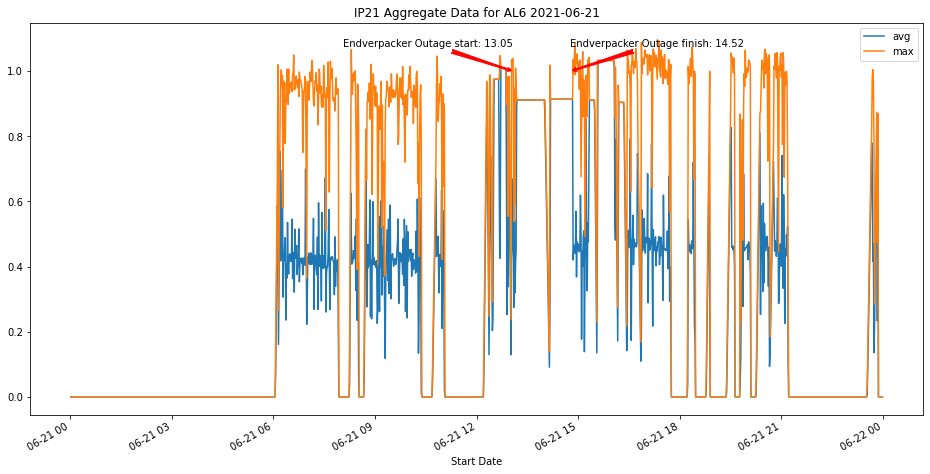

In [72]:
import matplotlib.pyplot as plt
df_IP21[['avg','max']][df_IP21.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8), title='IP21 Aggregate Data for AL6 2021-06-21')
# plt.annotate(s='',Direction xy=('2021-06-21 13:05:00', 60), xytext=('2021-06-21 13:05:00', 0), arrowprops=dict(arrowstyle='<-<')
# plt.show())
plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

In [54]:
df_IP21[df_IP21.name.str.contains('36630901_S130HEIGHT_L9')]

avg     0.272346
min     0.136614
max     0.432727
std     0.076154
sum    16.340738
dtype: float64

read in the HISTORY table csv which is built using this statement

```
for (select NAME, FIELD_ID, TS, PERIOD, REQUEST, STEPPED, VALUE, STATUS, SECONDS
 from history
where name like '366%'
  and ts between '21-Jun-21 00:00:00.0' and '21-Jun-21 23:59:59.9') do 
	write name || ',' || field_id || ',' || ts || ',' || period || ',' || request || ',' || stepped || ',' || value || ',' || status || ',' || seconds;
end
```


In [60]:
# read in txt file
file = (dir + 'IP21_AL6_History_20210621.txt')
df_IP21_hist = pd.read_csv(file, parse_dates=True, index_col='Timestamp', header=None, names=('name', 'field_id', 'Timestamp', 'period', 'request', 'stepped', 'value','status','seconds'))
df_IP21_hist.shape

(249120, 8)

In [62]:
df_IP21_hist.head()

,name,field_id,period,request,stepped,value,status,seconds
Timestamp,,,,,,,,
2021-06-21 00:00:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226400
2021-06-21 00:01:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226460
2021-06-21 00:02:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226520
2021-06-21 00:03:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226580
2021-06-21 00:04:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226640


Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

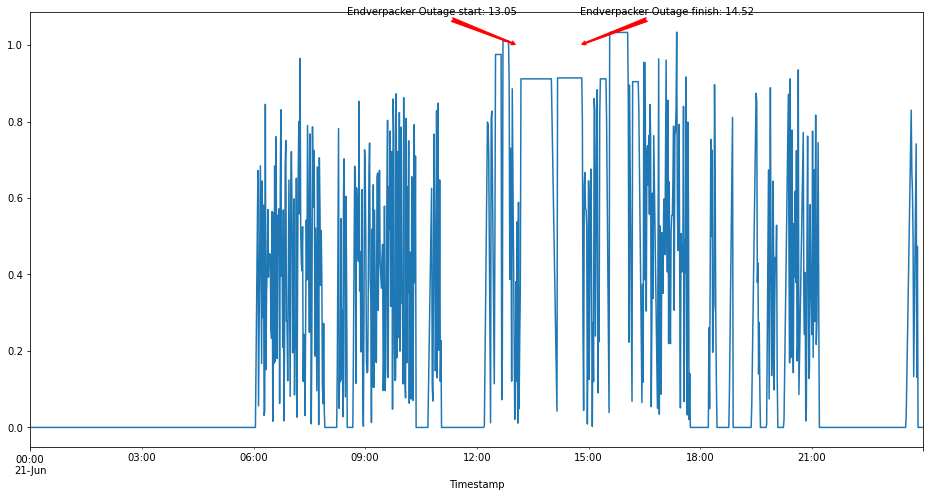

In [69]:
df_IP21_hist['value'][df_IP21_hist.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8))

plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

In [74]:
df_IP21_agg.info()

NameError: name 'df_IP21_agg' is not defined